# Udacity Self Driving Car Nanodegree P4

### Project aims to show lane line, the position of vehicle with respect to the road and finally to determine the radius of curvature of the road.

## 0. Importing libraries

In [1]:
# basic libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from moviepy.editor import VideoFileClip
%matplotlib inline

## 1. Distortion Correction

### Distortion is very common in images. So the images are to be corrected. This is performed using the camera calibration matrix and distortion coefficient. Also we have a set of chess images that can be used for this calculation 

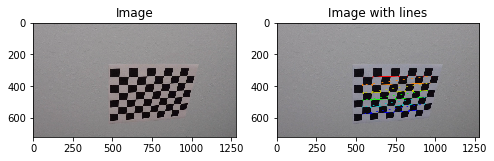

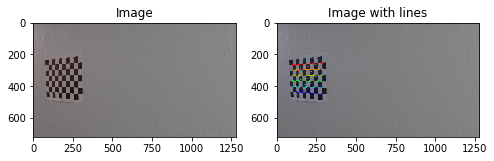

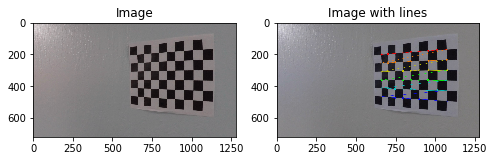

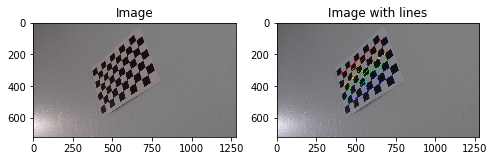

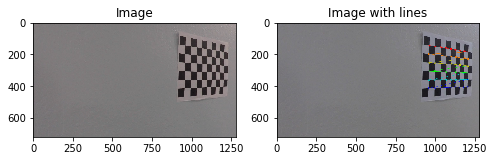

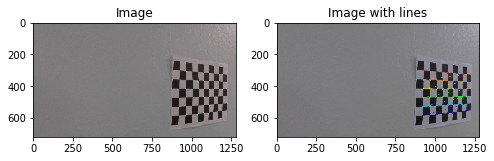

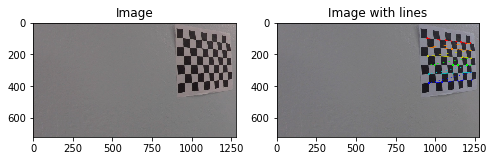

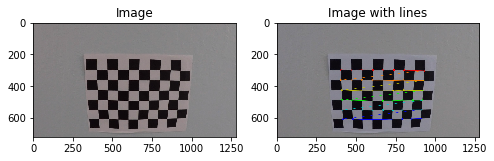

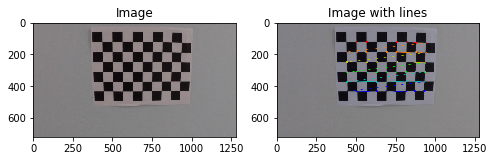

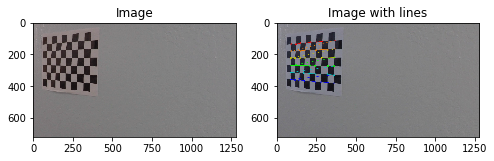

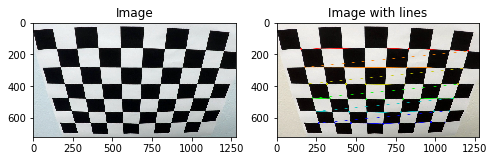

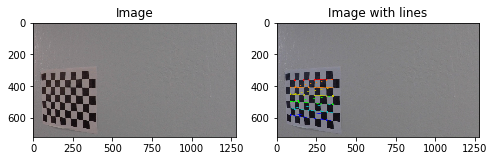

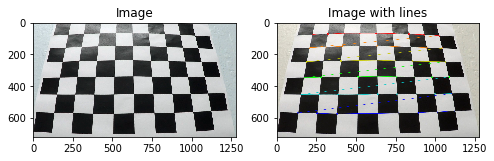

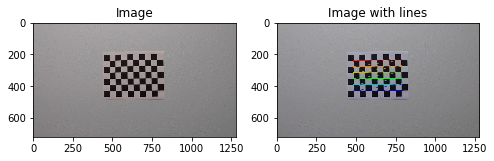

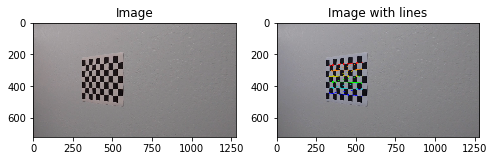

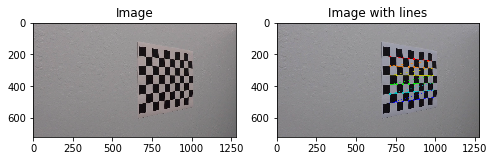

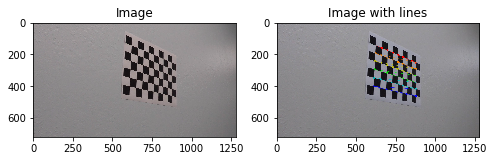

In [2]:
# object points in 3D universe
object_point = []
# image plane points
image_point = [] 
import glob
images = glob.glob('camera_cal/calibration*.jpg')
import cv2
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# function to calaculate Camera callibration matrix and to display the results
def camera_calibration_function(images):

    for index, indexed_name in enumerate(images):
        # read image
        img = cv2.imread(indexed_name)

        # convert to grayscale image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        nx = 9
        ny = 6
        # chessboard corners detect
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if (ret == True):
            object_point.append(objp)
            image_point.append(corners)
            
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            dummy, (axis_one, axis_two) = plt.subplots(1, 2, figsize=(8,4))

            # Unmodified image
            axis_one.imshow(cv2.cvtColor(mpimg.imread(indexed_name), cv2.COLOR_BGR2RGB))
            axis_one.set_title('Image')

            # Image with corners detected
            axis_two.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axis_two.set_title('Image with lines')

# function call to camera_calibration
camera_calibration_function(images)


In [3]:
# function to calculate zero_like
def mirror_function(var):
    var_1 = np.zeros_like(var)
    return var_1

In [4]:
# function to calculate polyfit
def poly_func(y_vals_lft, x_vals_lft):
        fit_lft = np.polyfit(y_vals_lft, x_vals_lft, 2)
        return fit_lft

In [5]:
# Functions: Distortion removal in images
def distortion_correction(test_image):
    # read image
    #img = cv2.imread(image)
    image_size = (test_image.shape[1], test_image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(object_point, image_point, image_size, None, None)
    undist_image = cv2.undistort(test_image, mtx, dist, None, mtx)
    return undist_image

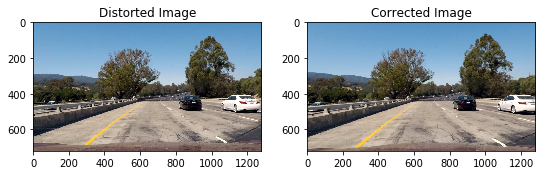

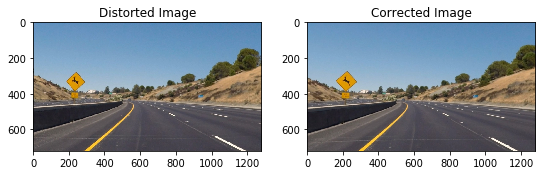

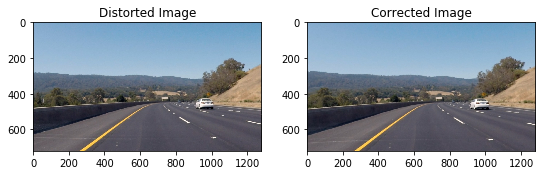

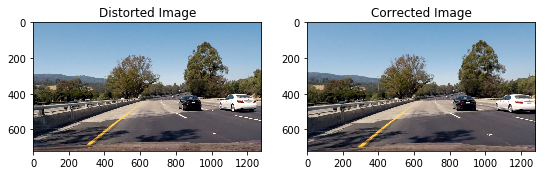

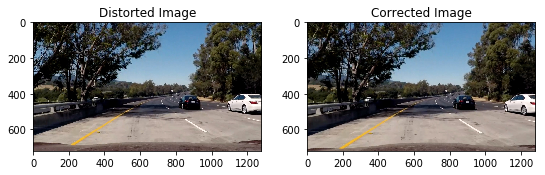

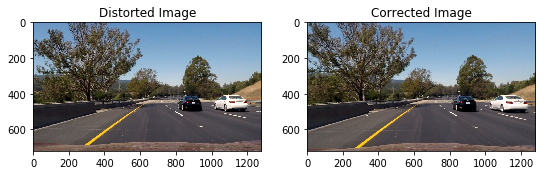

In [6]:
# Display distortion correction images
data_images = glob.glob('test_images/test*.jpg')
for test_image_link in data_images:
    test_image = cv2.imread(test_image_link)
    undist_dummy = distortion_correction(test_image)
    nx = 9
    ny = 6
    dummy, (axis_one, axis_two) = plt.subplots(1, 2, figsize=(nx,ny))
        
    # Distorted Image
    axis_one.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    axis_one.set_title('Distorted Image')
       
    # Corrected Image
    axis_two.imshow(cv2.cvtColor(undist_dummy, cv2.COLOR_BGR2RGB))
    axis_two.set_title('Corrected Image')

## 2. Perspective Transform 
### function bird_view is used to calculate perspective transform of the input image. function_view helps to convert image to bird's view such that we can measure lane lines and it's radius of curvature can be measures easily.

In [7]:
# function to get bird eye view
def bird_view(img):
    undistorted_image = distortion_correction(img) 
    image_size = (undistorted_image.shape[1], undistorted_image.shape[0])
    source_image = np.float32([[500, 480],[800, 480],[1250, 700],[40, 700]])
    destination_image = np.float32([[0, 0], [1280, 0], [1250, 700],[40, 700]])
    #source_image = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    #destination_image = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(source_image, destination_image)
    M_inverse = cv2.getPerspectiveTransform(destination_image, source_image)
    warped_image = cv2.warpPerspective(undistorted_image, M, image_size) 
    return undistorted_image, warped_image, M

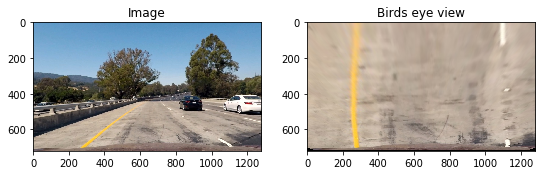

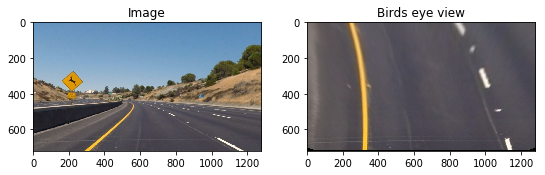

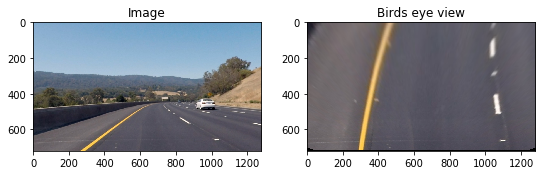

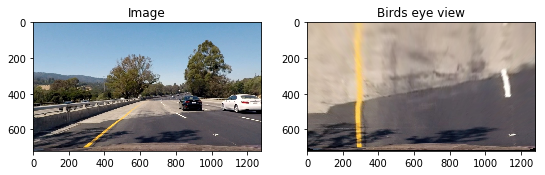

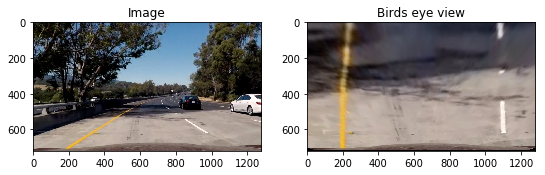

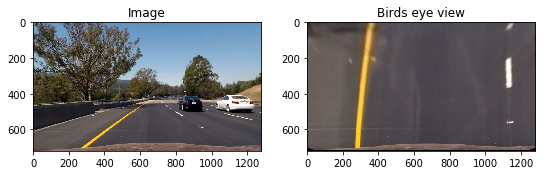

In [8]:
# display bird eye view of images
data_images = glob.glob('test_images/test*.jpg')
for test_image_link in data_images:
    test_image = cv2.imread(test_image_link)
    undistorted_image, warped_image, M = bird_view(test_image)
    dummy, (axis_one, axis_two) = plt.subplots(1, 2, figsize=(9, 6)) 
    
    # Undistorted image
    axis_one.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
    axis_one.set_title('Image')
        
    # Warped image
    axis_two.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
    axis_two.set_title('Birds eye view')

## 3. Binary Transform
### In binary transofrm section, different color spaces and gray scale transform is applied on the input image to detect lane lines. I had tried gray scale, LUV color space and LAB color space to monitor the result.
### I observed that use of L channel from LUV color space helps to detect lane lines. It worked great for white line but poor for yellow lane line. So I had to find a means to detect yellow lane lines. I tried B channel from LAB color space for this. It worked great for yellow line but poor for white lane line.
### So the best means to detect lane lines are by combining L channel from LUV color space and B channel from LAB color space. The threshold values are as follows for each of the color space.
#### 1. L channel (LUV color space): minimum threshold = 228, maximum threshold = 255
#### 2. B channel (LAB color space): minimum threshold = 154, maximum threshold = 204

In [9]:
# function to perform LUV and LAB color space transform
def threshold_function(image_1):
    undistorted_image, image, M = bird_view(image_1)
    
    # 1. Gray scale transform
    thresh_gray = (180, 255)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    binary_thresh = mirror_function(gray)
    binary_thresh[(gray > thresh_gray[0]) & (gray <= thresh_gray[1])]
    
    # 2. LUV color space
    # I use L channel to detect lane lines. 
    #It worked great for white line but poor for yellow lane line
    L_ch = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0]
    U_ch = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,1]
    V_ch = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,2]
    
    L_thresh = mirror_function(V_ch)
    L_thresh[(L_ch > 227) & (L_ch < 256)] = 1
    
    # 3. LAB color space
    # I use B channel to detect lane lines. 
    #It worked great for yellow line but poor for white lane line
    L_ch = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,0]
    A_ch = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,1]
    B_ch = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,2]   
    
    B_thresh = np.zeros_like(A_ch)
    B_thresh[(B_ch > 153) & (B_ch < 205)] = 1
    
    # Combined binary threshold
    final_thresh = mirror_function(L_thresh)
    final_thresh[(L_thresh == 1) | (B_thresh == 1)] = 1
    return final_thresh, B_thresh, L_thresh, image

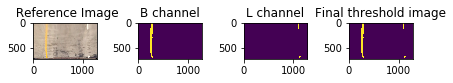

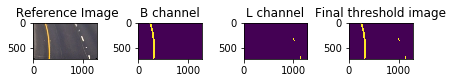

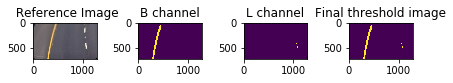

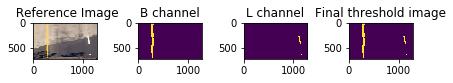

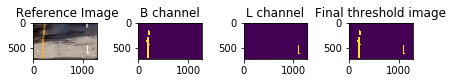

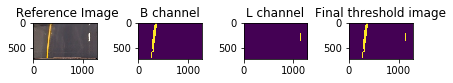

In [10]:
# function to display LUV and LAB transformed color spaces
data_images = glob.glob('test_images/test*.jpg')
for test_image_link in data_images:
    test_image = cv2.imread(test_image_link)
    final_thresh, B_thresh, L_thresh, image = threshold_function(test_image)
    dummy, (tit_1, tit_2, tit_3, tit_4) = plt.subplots(1, 4)  
    dummy.tight_layout()
    
    # warped image
    tit_1.set_title(' Reference Image')
    tit_1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # B channel
    tit_2.set_title('B channel')
    tit_2.imshow(B_thresh)
    
    # L channel
    tit_3.set_title('L channel')
    tit_3.imshow(L_thresh)

    # Combined thresholded image
    tit_4.set_title('Final threshold image')
    tit_4.imshow(final_thresh)

## 4. Lane detector
### This section deals with lane_detector function which helps to detect lane lines for both left and right and fit a polynomial into  each of them. The lane lines get detected by identifying the peaks in histogram transform of the image and monitoring pixels near these peaks. The area between the lane line is filled and highlighted for ease of understanding to the reader.
### The position of the car with respect to the lane lines are also calculated and displayed to the user.
### The help from Udacity is used to calculate the radius of curvature and this result is also displayed to the user.

In [11]:
# function to detect lane lines
def lane_detector(image, image_link):
    
    final_thresh, B_thresh, L_thresh, image_1 = threshold_function(image)
    rgt_x,rgt_y, lft_x, lft_y = [], [], [], []
    
    x_nonzero, y_nonzero = np.nonzero(np.transpose(final_thresh))
    band_end = 720
    band_begin = 630
    band_thresh = 23
    mid_row = 640 
    while band_begin > -2:
        band_sum = np.sum(final_thresh[band_begin:band_end,:], axis=0)
        
        argmax_l = np.argmax(band_sum[:mid_row])
        x_index = np.where((((argmax_l - band_thresh) < x_nonzero)&(x_nonzero < (argmax_l + band_thresh))&((y_nonzero > band_begin) & (y_nonzero < band_end))))
        x_window = x_nonzero[x_index] 
        y_window = y_nonzero[x_index]
        if (np.sum(x_window) != 0):
            lft_x.extend(x_window.tolist())
            lft_y.extend(y_window.tolist())
            
        argmax_r = np.argmax(band_sum[mid_row:]) + mid_row
        x_index = np.where((((argmax_r - band_thresh) < x_nonzero)&(x_nonzero < (argmax_r + band_thresh))&((y_nonzero > band_begin) & (y_nonzero < band_end))))
        x_window = x_nonzero[x_index] 
        y_window = y_nonzero[x_index]
        if (np.sum(x_window) != 0):
            rgt_x.extend(x_window.tolist())
            rgt_y.extend(y_window.tolist())
            
        band_begin = band_begin - 90
        band_end = band_end - 90
    
    lft_y = np.array(lft_y)
    lft_x = np.array(lft_x)
    rgt_y = np.array(rgt_y)
    rgt_x = np.array(rgt_x)
    
    # fitting polynomial along the point
    fit_lft = poly_func(lft_y, lft_x)
    fit_lft_x = fit_lft[0]*lft_y**2 + fit_lft[1]*lft_y + fit_lft[2]
    fit_rgt = poly_func(rgt_y, rgt_x)
    fit_rgt_x = fit_rgt[0]*rgt_y**2 + fit_rgt[1]*rgt_y + fit_rgt[2]
    rgt_x_t = fit_rgt[0]*720**2 + fit_rgt[1]*720 + fit_rgt[2]
    
    rgt_x = np.append(rgt_x, rgt_x_t)
    rgt_y = np.append(rgt_y, 720)
    rgt_x = np.append(rgt_x, fit_rgt[0]*0**2 + fit_rgt[1]*0 + fit_rgt[2])
    rgt_y = np.append(rgt_y, 0)
    
    lft_x_t = fit_lft[0]*720**2 + fit_lft[1]*720 + fit_lft[2]
    lft_x = np.append(lft_x, lft_x_t)
    lft_y = np.append(lft_y, 720)
    lft_x = np.append(lft_x,fit_lft[0]*0**2 + fit_lft[1]*0 + fit_lft[2])
    lft_y = np.append(lft_y, 0)
    
    srt_lft = np.argsort(lft_y)
    srt_rgt = np.argsort(rgt_y)
    lft_y = lft_y[srt_lft]
    lft_x = lft_x[srt_lft]
    rgt_y = rgt_y[srt_rgt]
    rgt_x = rgt_x[srt_rgt]
    fit_lft = poly_func(lft_y, lft_x)
    fit_lft_x = fit_lft[0]*lft_y**2 + fit_lft[1]*lft_y + fit_lft[2]
    fit_rgt = poly_func(rgt_y, rgt_x)
    fit_rgt_x = fit_rgt[0]*rgt_y**2 + fit_rgt[1]*rgt_y + fit_rgt[2]
    
    # section to calculate the curvature radius of the lane
    ym_per_pix = 0.0416666667 # equation to calculate distance per pixel in y axis
    xm_per_pix = 0.0052857143# equation to calculate distance per pixel in x axis
    left_fit_cr = poly_func(lft_y*ym_per_pix, lft_x*xm_per_pix)
    right_fit_cr = poly_func(rgt_y*ym_per_pix, rgt_x*xm_per_pix)
    curve_radius_lft = ((1 + (2*left_fit_cr[0]*np.max(lft_y) + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    curve_radius_rgt = ((1 + (2*right_fit_cr[0]*np.max(lft_y) + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # vehicle is positioned in the center of the lane
    center = abs(mid_row - ((rgt_x_t+lft_x_t)/2))

    source_image = np.float32([[500, 480],[800, 480],[1250, 700],[40, 700]])
    destination_image = np.float32([[0, 0], [1280, 0], [1250, 700],[40, 700]])
    #source_image = np.float32([[490, 482],[810, 482],[1250, 720],[40, 720]])
    #destination_image = np.float32([[0, 0], [1280, 0], [1250, 720],[40, 720]])
    
    M_new = cv2.getPerspectiveTransform(destination_image, source_image)
    
    undistorted_image_dummy, warped_image_dummy, M_new1 = bird_view(image)
    
    zero_warped = mirror_function(final_thresh).astype(np.uint8)
    warp_3_layers = np.dstack((zero_warped, zero_warped, zero_warped))
    
    lft_points = np.array([np.flipud(np.transpose(np.vstack([fit_lft_x, lft_y])))])
    rgt_points = np.array([np.transpose(np.vstack([fit_rgt_x, rgt_y]))])
    complete_points = np.hstack((lft_points, rgt_points))
    
    cv2.polylines(warp_3_layers, np.int_([complete_points]), isClosed=False, color=(0,0,240), thickness = 35)
    cv2.fillPoly(warp_3_layers, np.int_([complete_points]), (0,240, 0))
    final_thresh_x_value = final_thresh.shape[1]
    final_thresh_y_value = final_thresh.shape[0]
    
    warp_final = cv2.warpPerspective(warp_3_layers, M_new, (final_thresh_x_value, final_thresh_y_value))
    final_image = cv2.addWeighted(cv2.imread(image_link), 1, warp_final, 0.37, 0)
    undistorted_image_1, warped_image_1, M_1 = bird_view(image)
    return warped_image_1, fit_lft_x, lft_y, fit_rgt_x, rgt_y, final_image, center, curve_radius_lft, curve_radius_rgt

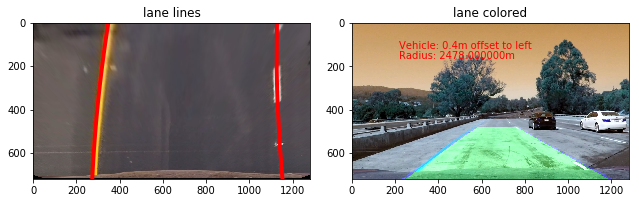

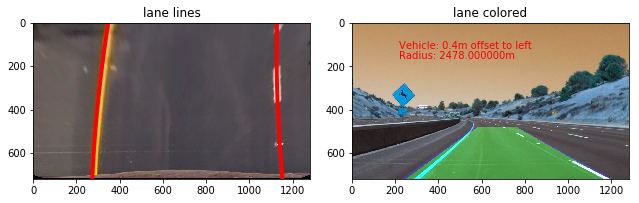

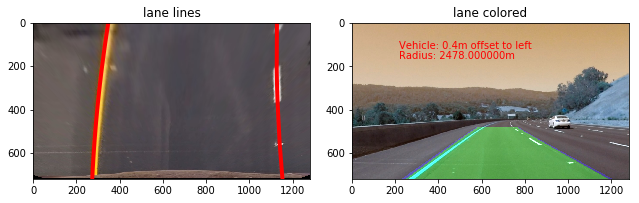

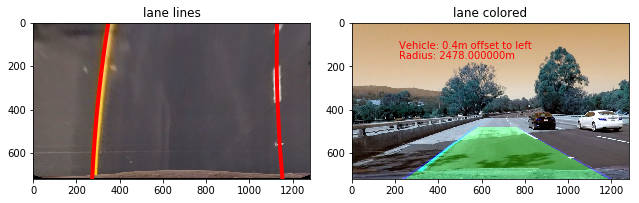

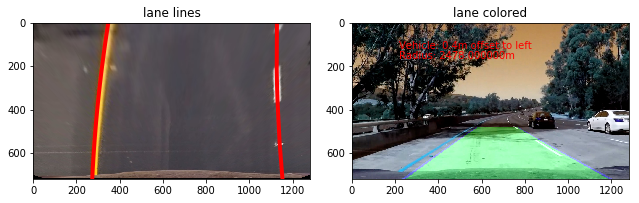

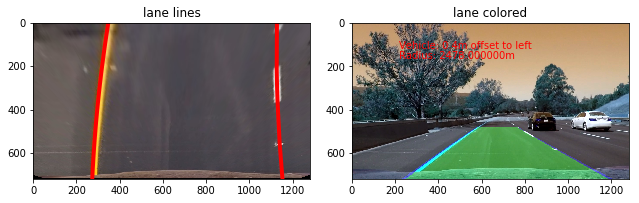

In [12]:
# function to display filled lane lines
data_images = glob.glob('test_images/test*.jpg')
for test_image_link in data_images:
    test = _image = cv2.imread(test_image_link)
    warped_image_1, fit_lft_x, lft_y, fit_rgt_x, rgt_y, final_image, center, curve_radius_lft, curve_radius_rgt = lane_detector(test_image, test_image_link)
    dummy1, (axis_1, axis_2) = plt.subplots(1,2, figsize=(9, 6))
    dummy1.tight_layout()
    axis_1.imshow(cv2.cvtColor((warped_image_1), cv2.COLOR_BGR2RGB))
    axis_1.set_xlim(0, 1280)
    axis_1.set_ylim(0, 720)
    axis_1.plot(fit_lft_x, lft_y, color='red', linewidth=4)
    axis_1.plot(fit_rgt_x, rgt_y, color='red', linewidth=4)
    axis_1.set_title('lane lines')
    axis_1.invert_yaxis() # to visualize as we do the images
    axis_2.imshow(final_image)
    axis_2.set_title('lane colored')
    if (center < 640):
        axis_2.text(220, 120, 'Vehicle: {:.1f}m offset to left'.format(center*3.7/700), color='red')
    elif (center >= 640):
        axis_2.text(220, 120, 'Vehicle: {:.1f}m offset to right'.format(center*3.7/700), color='red')
    axis_2.text(220, 165, 'Radius: {:1f}m'.format(int((curve_radius_lft + curve_radius_rgt)/2)), color='red')

## 5. Lane detector in video
### I have defined a class Line, as suggested by Udacity which stores all the attributes of each of the lane lines, both left and right. There are numerous methods used in the class which are basically a wrapper over the function used to perform the same for images.
### There are few members in th class Line which is used to keep track of information in the previous frame and current frame.

In [13]:
# class for the left and right lanes

from collections import deque
class Line:
    def __init__(self):
        self.detected = False
        self.radius_of_curvature = None
        self.recent_xfitted = [] 
        self.best_fit0 = deque(maxlen=10)
        self.best_fit1 = deque(maxlen=10)
        self.best_fit2 = deque(maxlen=10)
        self.best_fitx = None
        self.best_points = []
        self.x_best_int = deque(maxlen=10)
        self.top_best = deque(maxlen=10)
        self.x_previous_int = None
        self.top_previous = None
        self.current_fit = [np.array([False])]  
        self.xvalue = None
        self.yvalue = None
        self.counter = 0
        self.line_base_pos = None 
        self.diffs = np.array([0,0,0], dtype='float') 
        self.allx = None  
        self.ally = None
        
    def laneline_finder(self, x_in, y_in):
        x_vals = []
        y_vals = []
        detect_return = self.detected
        if (return_detect == True): 
            band_end = 720
            band_begin = 630
            band_threshold = 23
            while band_begin > -2:
                y_val = np.mean((band_begin, band_end))
                x_val = (np.mean(self.best_fit0))*y_val**2 + (np.mean(self.best_fit1))*y_val + (np.mean(self.best_fit2))
                x_val_min = x_val - band_threshold
                x_val_max = x_val + band_threshold
                x_index = np.where((((x_val_min) < x_in)&(x_in < (x_val_max))&((y_in > band_begin) & (y_in < band_end))))
                x_window, y_window = x_in[x_index], y[x_index]
                if np.sum(x_window) != 0:
                    #x_vals.extend(x_window.tolist())
                    #y_vals.extend(y_window.tolist())
                    np.append(x_vals, x_window)
                    np.append(y_vals, y_window)
                band_begin = band_begin - 90
                band_end = band_end - 90
        
        if (np.sum(x_vals) == 0): 
            self.detected = False
        detect_return = self.detected
        return x_vals, y_vals, detect_return
    
    def search_random(self, x_in, y_in, img_in):
        x_vals = []
        y_vals = []
        detect_return = self.detected
        if (detect_return != True): 
            band_end = 720
            band_begin = 630
            band_threshold = 23
            band_mid = 640
            while band_begin > -2:
                band_sum = np.sum(img_in[band_begin:band_end,:], axis=0)
                if(self == rgt_line):
                    peak_left_or_right = np.argmax(band_sum[band_mid:]) + band_mid
                elif(self != rgt_line):
                    peak_left_or_right = np.argmax(band_sum[:band_mid])
            x_index = np.where((((peak_left_or_right - band_thresh) < x_in)&(x_in < (peak_left_or_right + band_thresh))&((y_in > band_begin) & (y_in < band_end))))
            x_window = x_in[x_index] 
            y_window = y_in[x_index]
            if (np.sum(x_window) != 0):
                #x_vals.extend(x_window.tolist())
                #y_vals.extend(y_window.tolist())
                x_vals.extend(x_window)
                y_vals.extend(y_window)   
            band_begin = band_begin - 90
            band_end = band_end - 90
        if (np.sum(x_vals) > 0): 
            self.detected = True 
        elif (np.sum(x_vals) <= 0):
            x_vals = self.xvalue
            y_vals = self.yvalue
        detect_return = self.detected
        return x_vals, y_vals, detect_return        
                
    def curve_rad(self, x_vals, y_vals):
        ym_per_pix = 30./720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meteres per pixel in x dimension
        curve_fit = poly_func(y_vals*ym_per_pix, x_vals*xm_per_pix)
        curved_radius = ((1 + (2*curve_fit[0]*np.max(y_vals) + curve_fit[1])**2)**1.5) /abs(2*fit_cr[0])
        return curved_radius, curve_fit
    
    def id_sorter(self, x_vals, y_vals):
        idx_sort = np.argsort(y_vals)
        y_vals_sort = y_vals[idx_sort] 
        x_vals_sort = x_vals[idx_sort]
        return x_vals_sort, y_vals_sort, idx_sort
    
    def intercept_finder(self, poly_vals):
        band_end = 720
        bottom_intercept = poly_vals[0]*band_end**2 + poly_vals[1]*band_end + poly_vals[2]
        top_intercept = poly_vals[0]*0**2 + poly_vals[1]*0 + poly_vals[2]
        return bottom_intercept, top_intercept

In [14]:
# function to show lane lines on video
def video_function(img_frame):
    band_end = 720
    img_frame_size = (img_frame.shape[1], img_frame.shape[0])

    # undistort image and warped_image
    undistorted_image, warped_image, M = bird_view(img_frame)

    # applied with threshold
    final_thresh, B_thresh, L_thresh, image = threshold_function(warped_image)
     
    # Identify all non zero pixels in the image
    x_non_zero, y_non_zero = np.nonzero(np.transpose(final_thresh)) 

    if (lft_line.detected == True): 
        x_vals_lft, y_vals_lft, lft_line.detected = lft_line.laneline_finder(x_non_zero, y_non_zero)
    if (lft_line.detected == False):
        x_vals_lft, y_vals_lft, lft_line.detected = lft_line.search_random(x_non_zero, y_non_zero, final_thresh)
        
    if (rgt_line.detected == True):
        x_vals_rgt, y_vals_rgt, rgt_line.detected = rgt_line.laneline_finder(x_non_zero, y_non_zero)
    if (rgt_line.detected == True):
        x_vals_rgt, y_vals_rgt, rgt_line.detected = rgt_line.search_random(x_non_zero, y_non_zero, final_thresh)

    y_vals_lft = np.array(y_vals_lft).astype(np.float32)
    x_vals_lft = np.array(x_vals_lft).astype(np.float32)
    y_vals_rgt = np.array(y_vals_rgt).astype(np.float32)
    x_vals_rgt = np.array(x_vals_rgt).astype(np.float32)
        
    # fit the points using poly_function
    fit_lft = poly_func(y_vals_lft, x_vals_lft, 2)
    
    # EXtend the curve to top and bottom of the image
    lft_x_int, lft_line_top = lft_line.intercept_finder(fit_lft)
    lft_line.x_int.append(lft_x_int)
    lft_line.best_top.append(lft_line_top)
    lft_x_int = np.mean(lft_line.x_int)
    lft_line_top = np.mean(lft_line.best_top)
    lft_line.previous_x_int = lft_x_int
    lft_line.previous_top = lft_line_top
    
    x_vals_lft = np.append( x_vals_lft, lft_x_int)
    y_vals_lft = np.append( y_vals_lft, band_end)
    x_vals_lft = np.append( x_vals_lft, lft_line_top)
    y_vals_lft = np.append( y_vals_lft, 0)
    
    # Sort performed
    x_vals_lft,  y_vals_lft, idx_sort = lft_line.id_sorter( x_vals_lft,  y_vals_lft)
    lft_line.xvalue =  x_vals_lft
    lft_line.yvalue =  y_vals_lft
    
    # Curve plotted again using the poly_func function
    fit_lft = poly_func(y_vals_lft, y_vals_lft, 2)
    #fit_lft = [np.mean(lft_line.best_fit0.append(fit_lft[0])),np.mean(lft_line.best_fit1.append(fit_lft[1])), np.mean(lft_line.best_fit2.append(fit_lft[2]))]
    lft_line.best_fit0.append(fit_lft[0])
    lft_line.best_fit1.append(fit_lft[1])
    lft_line.best_fit2.append(fit_lft[2])
    fit_lft = [np.mean(lft_line.best_fit0), 
                np.mean(lft_line.best_fit1), 
                np.mean(lft_line.best_fit2)]
    
    # Fit left polynomial to detected pixels
    fit_lft_x = fit_lft[0]*y_vals_lft**2 + fit_lft[1]*y_vals_lft + fit_lft[2]
    lft_line.best_fitx = fit_lft_x
    
    # Radius calculated for leftlane and right lane
    curve_radius_lft, curve_fit_lft = lft_line.curve_rad(x_vals_lft, y_vals_lft)     
        
    # Fit right polynomial to detected pixels
    fit_rgt = poly_func(y_vals_rgt, x_vals_rgt,2)

    # EXtend the curve to top and bottom of the image
    rgt_x_int, rgt_line_top = rgt_line.intercept_finder(fit_rgt)
    rgt_line.x_int.append(rgt_x_int)
    rgt_line.best_top.append(rgt_line_top)
    rgt_x_int = np.mean(rgt_line.x_int)
    rgt_line_top = np.mean(rgt_line.best_top)
    rgt.previous_x_int = rgt_x_int
    rgt_line.previous_top = rgt_line_top
    
    x_vals_rgt = np.append( x_vals_rgt, rgt_x_int)
    y_vals_rgt = np.append( y_vals_rgt, band_end)
    x_vals_rgt = np.append( x_vals_lft, rgt_line_top)
    y_vals_rgt = np.append( y_vals_rgt, 0)
    
    # Sort right lane pixels  
    x_vals_rgt,  y_vals_rgt, idx_sort = rgt_line.id_sorter( x_vals_rgt,  y_vals_rgt)
    rgt_line.xvalue =  x_vals_rgt
    rgt_line.yvalue =  y_vals_rgt
    
    # Recalculate polynomial with intercepts and average across n frames   
    fit_rgt = poly_func(y_vals_rgt, y_vals_rgt, 2)
    fit_rgt = [np.mean(rgt_line.best_fit0.append(fit_rgt[0])),np.mean(rgt_line.best_fit1.append(fit_rgt[1])), np.mean(rgt_line.best_fit2.append(fit_rgt[2]))]
    rgt_line.best_fit0.append(fit_rgt[0])
    rgt_line.best_fit1.append(fit_rgt[1])
    rgt_line.best_fit2.append(fit_rgt[2])
    fit_rgt = [np.mean(rgt_line.best_fit0), 
                np.mean(rgt_line.best_fit1), 
                np.mean(rgt_line.best_fit2)]
    
    # Fit polynomial to detected pixels
    fit_rgt_x = fit_rgt[0]*y_vals_rgt**2 + fit_rgt[1]*y_vals_rgt + fit_rgt[2]
    rgt_line.best_fitx = fit_rgt_x
    
    # Compute radius of curvature for each lane in meters
    curve_radius_lft, curve_fit_lft = lft_line.curve_rad(x_vals_lft, y_vals_lft)
        
    # radius of curvature every 5 frames for improved readability
    frame_len = 3
    if (rgt_line.count % frame_len == 0):
        rgt_line.radius_of_curvature = curve_radius_rgt
        lft_line.radius_of_curvature = curve_radius_lft
    
    # Calculate the vehicle position relative to the center of the lane 
    mid_row = 640
    center = abs((mid_row - ((rgt_x_t+lft_x_t)/2))*3.7/700)

    source_image = np.float32([[500, 480],[800, 480],[1250, 700],[40, 700]])
    destination_image = np.float32([[0, 0], [1280, 0], [1250, 700],[40, 700]])
    
    M_new = cv2.getPerspectiveTransform(destination_image, source_image)
    
    zero_warped = mirror_function(final_thresh).astype(np.uint8)
    warp_3_layers = np.dstack((zero_warped, zero_warped, zero_warped))
    
    lft_points = np.array([np.flipud(np.transpose(np.vstack([lft_line.best_fitx, lft_line.yvalue])))])
    rgt_points = np.array([np.transpose(np.vstack([fit_rgt_x, rgt_line.yvalue]))])
    complete_points = np.hstack((lft_points, rgt_points))

    cv2.polylines(warp_3_layers, np.int_([complete_points]), isClosed=False, color=(0,0,240), thickness = 35)
    cv2.fillPoly(warp_3_layers, np.int_([complete_points]), (45,240, 45))
    final_thresh_x_value = img_frame.shape[1]
    final_thresh_y_value = image_frame.shape[0]
    #final_thresh_y_value = final_thresh.shape[0]
    
    warp_final = cv2.warpPerspective(warp_3_layers, M_new, (final_thresh_x_value, final_thresh_y_value))
    #final_image = cv2.addWeighted(cv2.imread(image_link), 1, warp_final, 0.37, 0)
    final_image = cv2.addWeighted(undistorted_image, 1, warp_final, 0.37, 0)
        
    # Print distance from center on video
    if ((rgt_x_t+lft_x_t) > 2*mid_row):
        cv2.putText(final_image, 'Vehicle: {:.3f} m offset to left'.format(center),(100, 100), color='red')
    elif((rgt_x_t+lft_x_t) <= 2*mid_row):
        cv2.putText(final_image, 'Vehicle: {:.3f} m offset to left'.format(center),(100, 100), color='red')
  
    # Print radius of curvature on video
    actual_radius_of_curvature = ((lft_line.radius_of_curvature+rgt_line.radius_of_curvature)/2)
    cv2.putText(result, 'Radius of Curvature {:.1f} m'.format(actual_radius_of_curvature), (130,150),color='red')
    lft_line.counter = lft_line.counter + 1
    return final_image

In [15]:
lft_line = Line()
rgt_line = Line()
video_output = 'result.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_vid) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████████████████████████████████▉| 1260/1261 [22:07<00:01,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



In [16]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))